### Data
We want sequence that are long enough where there is room to forget token kvs with minimal information loss.

In [3]:
from tqdm.auto import tqdm
from datasets import load_dataset
import numpy as  np
from transformers import GPT2Tokenizer

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
dataset = load_dataset('wikitext', 'wikitext-103-v1')
split = dataset['train']

In [ ]:
# compute text with token length >= 512
batch = 500
min_tok_length = 512
filtered = []
lengths = []
max_length = 0
for i in tqdm(range(0, len(split), batch)):
    lengths += [len(tok) for tok in tokenizer.batch_encode_plus([split[min(i+j, len(split) - 1)]['text'] for j in range(batch)])['input_ids']]

In [34]:
np.save('token_length.npy', np.array(lengths))

In [5]:
l = np.load('token_length.npy')

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all([len(tok) > 512 for tok in tokenizer.batch_encode_plus([split[int(i)]['text'] for i in np.where(l > 512)[0][:20]])['input_ids']])

True

Text(0.5, 1.0, 'num sequences with L > x')

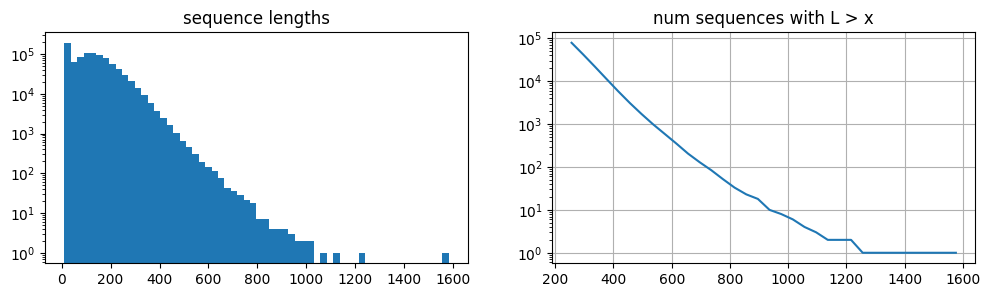

In [30]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(l[l > 10], bins=60)
ax[0].set_yscale('log')
ax[0].set_title('sequence lengths')

tot = []
step = 40
r = range(256, l.max(), step)
ax[1].plot(r, [(l>i).sum() for i in r])
ax[1].grid()
ax[1].set_yscale('log')
ax[1].set_title('num sequences with L > x')

In [214]:
(l > 400).sum()

7626

### Analyis
Study sensitivity in relation to ratio of forgotten kvs as well as timestep of pruning start.

Test pruning (no-FT) based on:
- similarity of k
- similarity of v
- min(sim_k, sim_v)
- cumulative attention weights
- Mix of above

Visualize ppl by number of tokens pruned, both with and without intermediate renormalization


### Apply to MHA (GPT2 WikiText)

In [1]:
import torch
import torch.nn as nn
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import transformers_drop_in as drop_in
import tensor_util as tu
from config import CONFIG

### Keys with high magnitude end up propagating to keys with lower magnitude
need to normalize keys first
TODO: use min symmetric ksim instead to normalized in order to accurately approximate similarities during forward pass

In [13]:
def consolidate_v1(key, value):
    keep_n = int(CONFIG.context_length * (1 - CONFIG.prune_ratio))

    # normalize keys so that high-magnitude keys dont dominate
    keyn = key / torch.sqrt((key**2).sum(dim=-1))[:,:,:,None]
    
    # compute K-similarity
    ksim = torch.matmul(keyn, keyn.transpose(-1, -2))
    ksim = nn.functional.softmax(ksim / CONFIG.temperature, dim=-1)

    OUTPUT.ksim = ksim.cpu()
    OUTPUT.keyn = key.cpu()
    
    # propagate values
    consolidate_v = torch.matmul(ksim, value)

    # # prune proportionally to diffusion rate (normalized K-sim weight placed on other keys)
    # tok_idx = torch.arange(ksim.size(0))
    # diffusion_rate = 1 - ksim[:,:,tok_idx,tok_idx]
    
    # TODO scale diffusion rate tensor to enforce prune ratio
    
    return key, consolidate_v

def normalize_keys(key, value):
    keyn = key / torch.sqrt((key**2).sum(dim=-1))[:,:,:,None]
    return keyn, value

def no_op(key, value):
    return key, value

drop_in.consolidate_kv = normalize_keys

In [13]:
CONFIG.do_consolidate = True
CONFIG.prune_ratio = 0.5
CONFIG.context_length = 400
CONFIG.consolidate_length = 200
CONFIG.temperature = 0.01
CONFIG.fix_prune_rate = True
CONFIG.ft_length = 200

In [4]:
batch_size = 1
ft_indices, = np.where(l >= CONFIG.context_length)
indices, = np.where(l > CONFIG.context_length)
batch_iter = iter(np.array_split(np.random.choice(indices, len(indices), replace=False), len(indices) // batch_size))

NameError: name 'l' is not defined

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(CONFIG.device)
# model.eval()

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.6.attn.scale_v.weight', 'h.9.attn.scale_v.weight', 'h.3.attn.scale_v.bias', 'h.2.attn.scale_v.bias', 'h.7.attn.scale_v.weight', 'h.3.attn.scale_v.weight', 'h.1.attn.scale_v.weight', 'h.0.attn.scale_v.bias', 'h.8.attn.scale_v.weight', 'h.11.attn.scale_v.weight', 'h.7.attn.scale_v.bias', 'h.9.attn.scale_v.bias', 'h.5.attn.scale_v.weight', 'h.4.attn.scale_v.weight', 'h.5.attn.scale_v.bias', 'h.1.attn.scale_v.bias', 'h.0.attn.scale_v.weight', 'h.11.attn.scale_v.bias', 'h.4.attn.scale_v.bias', 'h.2.attn.scale_v.weight', 'h.10.attn.scale_v.bias', 'h.6.attn.scale_v.bias', 'h.10.attn.scale_v.weight', 'h.8.attn.scale_v.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model.load_state_dict(torch.load('qknorm_model.pt'))
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2AttentionDropIn(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (scale_v): Conv1D()
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
batch_size = 1
no_loss_label = -100  # used to make CE loss ignore this element
indices, = np.where(l > CONFIG.context_length)
nlls = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(np.array_split(indices, len(indices) // batch_size))):
        model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                     return_tensors="pt",
                                                                                     truncation=True,
                                                                                     max_length=CONFIG.context_length).items()}
        labels = model_input['input_ids'].clone()
        labels[:,:CONFIG.consolidate_length] = no_loss_label
        labels[:,CONFIG.context_length:] = no_loss_label
        out = model(**model_input, labels=labels)  # forward pass handles predicted token time shift
        nlls += [out.loss]
ppl = torch.exp(torch.stack(nlls).mean())

In [127]:
ppl = torch.exp(torch.stack(nlls).mean())
ppl

tensor(29.1154, device='cuda:0')

In [9]:
ppl  # published result is 37.50

tensor(37.0557, device='cuda:0')

In [13]:
ppl  # computed over LOSS_RANGE (lower since tokens we compute loss for now have more prior information)

tensor(29.7449, device='cuda:0')

### Finetune for QKNorm

In [4]:
from tqdm.auto import tqdm
from datasets import load_dataset
import numpy as  np
from transformers import GPT2Tokenizer

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
dataset = load_dataset('wikitext', 'wikitext-103-v1')
split = dataset['train']

In [6]:
l = np.load('token_length.npy')

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import transformers_drop_in as drop_in
import tensor_util as tu
from config import CONFIG
from torch.optim import Adam
import wandb

In [ ]:
wandb.login()

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load('qknorm_model.pt'))
model.cuda()

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.4.attn.scale_v.weight', 'h.11.attn.scale_v.weight', 'h.8.attn.scale_v.bias', 'h.3.attn.scale_v.bias', 'h.6.attn.scale_v.bias', 'h.1.attn.scale_v.bias', 'h.9.attn.scale_v.bias', 'h.4.attn.scale_v.bias', 'h.5.attn.scale_v.bias', 'h.10.attn.scale_v.bias', 'h.11.attn.scale_v.bias', 'h.8.attn.scale_v.weight', 'h.5.attn.scale_v.weight', 'h.2.attn.scale_v.weight', 'h.0.attn.scale_v.weight', 'h.0.attn.scale_v.bias', 'h.6.attn.scale_v.weight', 'h.7.attn.scale_v.weight', 'h.10.attn.scale_v.weight', 'h.3.attn.scale_v.weight', 'h.9.attn.scale_v.weight', 'h.7.attn.scale_v.bias', 'h.2.attn.scale_v.bias', 'h.1.attn.scale_v.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2AttentionDropIn(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (scale_v): ScaleHead()
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [16]:
model.load_state_dict(torch.load('qknorm_model.pt'))

<All keys matched successfully>

In [16]:
model.transformer.h[0].attn.scale_v.weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)

In [31]:
optim.zero_grad()

In [9]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

wandb: Currently logged in as: isaacrehg (isaac-rehg). Use `wandb login --relogin` to force relogin


In [11]:
CONFIG.context_length = 400
CONFIG.train_length = 200
batch_size = 2
effective_batch_size = 64
batches_per_update = effective_batch_size // batch_size
optim = Adam(drop_in.GLOBALS.new_params, lr=1e-3)
log_interval = 50
loss = 0
ft_indices, = np.where(np.bitwise_and(l < CONFIG.context_length, l >= CONFIG.train_length))
ft_indices = np.random.choice(ft_indices, len(ft_indices), replace=False)
for i, batch in enumerate(tqdm(np.array_split(ft_indices, len(ft_indices) // batch_size))):
    model_input = {name: t.to(CONFIG.device) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                 return_tensors="pt",
                                                                                 truncation=True,
                                                                                 max_length=CONFIG.train_length).items()}
    labels = model_input['input_ids'].clone()
    # labels[:,:CONFIG.consolidate_length] = no_loss_label
    # labels[:,CONFIG.context_length:] = no_loss_label
    out = model(**model_input, labels=labels)  # forward pass handles predicted token time shift
    (out.loss / batches_per_update).backward()
    loss += out.loss.cpu() / batches_per_update

    if (i + 1) % batches_per_update == 0:
        optim.step()
        optim.zero_grad()
        print(f"{i}: Loss={loss}, PPL={torch.exp(loss)}")
        wandb.log({"loss": loss, "ppl": torch.exp(loss)})
        loss = 0


  0%|          | 0/85479 [00:00<?, ?it/s]

31: Loss=7.866733074188232, PPL=2609.028076171875
63: Loss=7.2956461906433105, PPL=1473.8690185546875
95: Loss=7.0081610679626465, PPL=1105.6195068359375
127: Loss=6.6625447273254395, PPL=782.5397338867188
159: Loss=6.551741123199463, PPL=700.4627075195312
191: Loss=6.451735496520996, PPL=633.80126953125
223: Loss=6.371002197265625, PPL=584.6434936523438
255: Loss=6.235105514526367, PPL=510.3544616699219
287: Loss=6.218237400054932, PPL=501.8179626464844
319: Loss=6.10561990737915, PPL=448.3705139160156


KeyboardInterrupt: 

In [7]:
        print(f"{i}: Loss={loss}, PPL={torch.exp(loss)}")


63: Loss=3.6243069171905518, PPL=37.49872589111328


In [27]:
        print(f"{i}: Loss={loss}, PPL={torch.exp(loss)}")


63: Loss=3.6243069171905518, PPL=37.49872589111328


In [25]:
optim.zero_grad()

In [9]:
h, scale_v = drop_in.GLOBALS.outputs[0]

In [10]:
scale_v.weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)

### Apply to MQA (GPTBigCode)